In [1]:
import requests
import json
import pandas as pd

url = "https://api.spacexdata.com/v4/launches/past"
response = requests.get(url)
data_obj = response.json()
with open('spacex_past_launches.json', 'w', encoding='utf-8') as f:
    json.dump(data_obj, f, ensure_ascii=False, indent=4)

print(data_obj)


[{'fairings': {'reused': False, 'recovery_attempt': False, 'recovered': False, 'ships': []}, 'links': {'patch': {'small': 'https://images2.imgbox.com/94/f2/NN6Ph45r_o.png', 'large': 'https://images2.imgbox.com/5b/02/QcxHUb5V_o.png'}, 'reddit': {'campaign': None, 'launch': None, 'media': None, 'recovery': None}, 'flickr': {'small': [], 'original': []}, 'presskit': None, 'webcast': 'https://www.youtube.com/watch?v=0a_00nJ_Y88', 'youtube_id': '0a_00nJ_Y88', 'article': 'https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html', 'wikipedia': 'https://en.wikipedia.org/wiki/DemoSat'}, 'static_fire_date_utc': '2006-03-17T00:00:00.000Z', 'static_fire_date_unix': 1142553600, 'net': False, 'window': 0, 'rocket': '5e9d0d95eda69955f709d1eb', 'success': False, 'failures': [{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}], 'details': 'Engine failure at 33 seconds and loss of vehicle', 'crew': [], 'ships': [], 'capsules': [], 'payloads': ['5eb0e4b5b6c3bb0006eeb1e1

In [6]:
import pandas as pd
# Convert to DataFrame
df_spacex = pd.json_normalize(data_obj)

# Save DataFrame to CSV
df_spacex.to_csv('spacex_past_launches.csv', index=False)
df_spacex

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,...,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],Ratsat was carried to orbit on the first succe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=dLQ2tZEH6G0,dLQ2tZEH6G0,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,NaN
4,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,True,[],None,[],[],...,None,None,[],[],http://www.spacex.com/press/2012/12/19/spacexs...,https://www.youtube.com/watch?v=yTaIDooc8Og,yTaIDooc8Og,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,None,NaN,False,NaN,5e9d0d95eda69973a809d1ec,True,[],None,[],[],...,None,https://www.reddit.com/r/spacex/comments/k2ts1...,[],[],None,https://youtu.be/NONM-xsKMSs,NONM-xsKMSs,None,None,NaN
183,None,NaN,False,NaN,5e9d0d95eda69973a809d1ec,True,[],None,[],[],...,None,https://www.reddit.com/r/spacex/comments/k2ts1...,[],[],None,None,None,None,None,NaN
184,None,NaN,False,NaN,5e9d0d95eda69973a809d1ec,True,[],None,[],[],...,None,https://www.reddit.com/r/spacex/comments/k2ts1...,[],[],None,https://youtu.be/ZlQHF_yBkMQ,ZlQHF_yBkMQ,None,None,NaN
185,None,NaN,False,NaN,5e9d0d95eda69973a809d1ec,True,[],None,[],[],...,None,https://www.reddit.com/r/spacex/comments/k2ts1...,[],[],None,https://youtu.be/VVu2bSJJhgI,VVu2bSJJhgI,None,None,NaN


In [8]:
# Filter the data for each unique rocket ID and analyze the number of launches for each ID
rocket_id_analysis = df_spacex.groupby('rocket').size().reset_index(name='Number of Launches')

rocket_id_analysis



,rocket,Number of Launches
0,5e9d0d95eda69955f709d1eb,5
1,5e9d0d95eda69973a809d1ec,179
2,5e9d0d95eda69974db09d1ed,3


In [10]:
# Create a new column "landing_outcome" based on the "success" column
df_spacex['landing_outcome'] = df_spacex['success'].apply(lambda x: 1 if x == True else 0)

# Summarize the number of successful and unsuccessful landings based on the "landing_outcome" column
landing_summary = df_spacex['landing_outcome'].value_counts().reset_index()
landing_summary.columns = ['Landing Outcome', 'Number of Occurrences']
landing_summary['Landing Outcome'] = landing_summary['Landing Outcome'].map({1: 'Successful', 0: 'Unsuccessful'})

landing_summary


,Landing Outcome,Number of Occurrences
0,Successful,181
1,Unsuccessful,6


In [13]:
# Calculate the percentage of missing values for each attribute/column
missing_values_percentage = df_spacex.isnull().mean() * 100

# Create a DataFrame to display the results
missing_values_df = pd.DataFrame({
    'Attribute': missing_values_percentage.index,
    'Missing Values Percentage': missing_values_percentage.values
})

# Sort by the percentage of missing values
missing_values_df = missing_values_df.sort_values(by='Missing Values Percentage', ascending=False)

missing_values_df



,Attribute,Missing Values Percentage
42,fairings,100.000000
23,launch_library_id,63.101604
27,fairings.recovered,54.545455
33,links.reddit.media,52.941176
37,links.presskit,51.336898
34,links.reddit.recovery,50.267380
25,fairings.reused,50.267380
26,fairings.recovery_attempt,42.780749
3,window,37.433155
1,static_fire_date_unix,35.294118


In [14]:
# Identify the data types of each column to determine which are numerical and which are categorical
column_data_types = df_spacex.dtypes

# Create a DataFrame to display the results
column_types_df = pd.DataFrame({
    'Attribute': column_data_types.index,
    'Data Type': column_data_types.values
})

# Classify columns as either 'Numerical' or 'Categorical'
column_types_df['Type'] = column_types_df['Data Type'].apply(lambda x: 'Numerical' if x in ['int64', 'float64'] else 'Categorical')

column_types_df


,Attribute,Data Type,Type
0,static_fire_date_utc,object,Categorical
1,static_fire_date_unix,float64,Numerical
2,net,bool,Categorical
3,window,float64,Numerical
4,rocket,object,Categorical
5,success,object,Categorical
6,failures,object,Categorical
7,details,object,Categorical
8,crew,object,Categorical
9,ships,object,Categorical


In [15]:
# Calculate the number of launches for each launch site based on the "launchpad" column
launch_site_counts = df_spacex['launchpad'].value_counts().reset_index()
launch_site_counts.columns = ['Launch Site', 'Number of Launches']

launch_site_counts


,Launch Site,Number of Launches
0,5e9e4501f509094ba4566f84,99
1,5e9e4502f509094188566f88,55
2,5e9e4502f509092b78566f87,28
3,5e9e4502f5090995de566f86,5


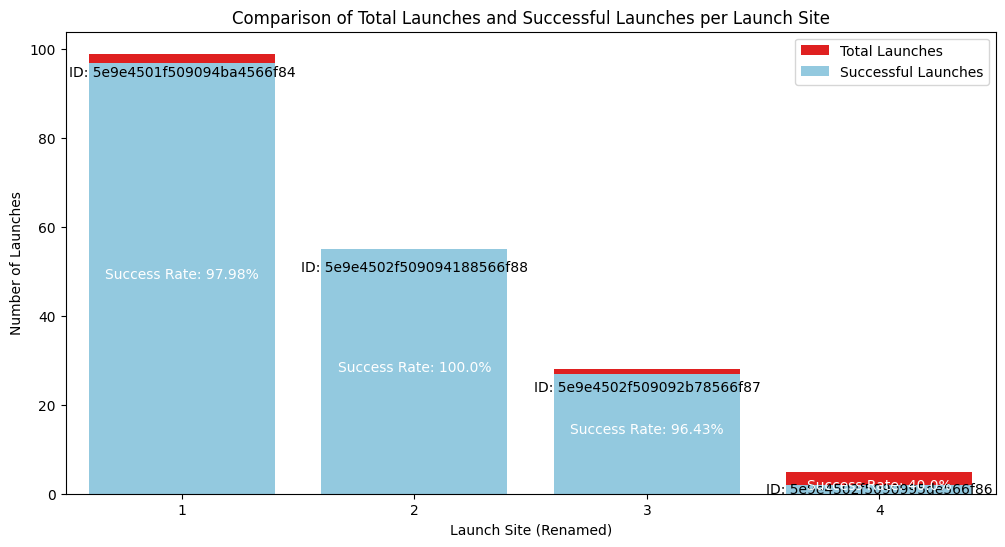

In [21]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a new column "landing_outcome" based on the "success" column
df_spacex['landing_outcome'] = df_spacex['success'].apply(lambda x: 1 if x == True else 0)

# Step 2: Identify the possible unique values for each column in the DataFrame
# This step was done interactively earlier

# Step 3: Calculate the number of launches for each launch site based on the "launchpad" column
launch_site_counts = df_spacex['launchpad'].value_counts().reset_index()
launch_site_counts.columns = ['Launch Site', 'Number of Launches']

# Step 4: Calculate the number of successful launches for each launch site
successful_launches = df_spacex[df_spacex['landing_outcome'] == 1]['launchpad'].value_counts().reset_index()
successful_launches.columns = ['Launch Site', 'Number of Successful Launches']

# Step 5: Merge the total launches and successful launches DataFrames
launch_comparison = pd.merge(launch_site_counts, successful_launches, on='Launch Site', how='left')
launch_comparison['Number of Successful Launches'].fillna(0, inplace=True)

# Step 6: Calculate the success rate for each launch site
launch_comparison['Success Rate'] = (launch_comparison['Number of Successful Launches'] / launch_comparison['Number of Launches']) * 100

# Step 7: Rename the launch sites to 1, 2, 3, 4 for better visualization
launch_comparison['Launch Site Name'] = ['1', '2', '3', '4']
launch_comparison['Success Rate'] = launch_comparison['Success Rate'].round(2)  # Round to 2 decimal places

# Step 8: Plotting with annotated labels
plt.figure(figsize=(12, 6))
bar1 = sns.barplot(x='Launch Site Name', y='Number of Launches', data=launch_comparison, label='Total Launches', color='red')
bar2 = sns.barplot(x='Launch Site Name', y='Number of Successful Launches', data=launch_comparison, label='Successful Launches', color='skyblue')

# Annotate with launch site IDs and success rates
for index, row in launch_comparison.iterrows():
    bar1.text(index, row['Number of Launches'] - 5, f"ID: {row['Launch Site']}", color='black', ha="center")
    bar1.text(index, row['Number of Successful Launches'] / 2, f"Success Rate: {row['Success Rate']}%", color='white', ha="center")

plt.title('Comparison of Total Launches and Successful Launches per Launch Site')
plt.xlabel('Launch Site (Renamed)')
plt.ylabel('Number of Launches')
plt.legend()
plt.show()




In [2]:
# Import required libraries
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px

# Read the CSV file into a DataFrame
df = pd.read_csv("spacex_past_launches.csv")

# Calculate the success rate for each launch site
success_rate_df = df.groupby('launchpad')['success'].agg(['count', 'sum']).reset_index()
success_rate_df['Success Rate (%)'] = (success_rate_df['sum'] / success_rate_df['count']) * 100

# Initialize the Dash app
app = dash.Dash(__name__)

# Create the Plotly figure
fig = px.bar(success_rate_df, 
             x='launchpad', 
             y='Success Rate (%)', 
             title='Success Rate of Each Launch Site',
             labels={'launchpad': 'Launch Site ID', 'Success Rate (%)': 'Success Rate (%)'},
             text='Success Rate (%)')
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Define the app layout
app.layout = html.Div([
    html.H1("SpaceX Launch Success Rate"),
    dcc.Graph(id='success-rate-bar-chart', figure=fig)
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)





In [2]:
# Import the Folium library
import folium

# Create a map centered around coordinates [36.5054, -117.0794] (Death Valley, California)
m = folium.Map(location=[36.5054, -117.0794], zoom_start=10)

# Add a marker for Death Valley
folium.Marker([36.5054, -117.0794], popup='Death Valley').add_to(m)

# Add a circle around Death Valley
folium.Circle(
    radius=5000,  # in meters
    location=[36.5054, -117.0794],
    popup='Death Valley Circle',
    color='blue',
    fill=True,
).add_to(m)

# Assume that you've used Google Maps API to find the number of nearby roads, which is 2 for this example
num_roads = 2
folium.Marker([36.5054, -117.0794], 
              popup=f'Death Valley: {num_roads} nearby roads', 
              icon=folium.Icon(color="green")).add_to(m)

# Show the map
m



